## Importy

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.src.layers import Bidirectional, LSTM, InputLayer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras import Sequential, Input
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense


from utils.dataset_tools import DatasetTools

2025-09-22 15:53:53.944580: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758549233.960169   28611 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758549233.964659   28611 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758549233.976108   28611 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758549233.976125   28611 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758549233.976126   28611 computation_placer.cc:177] computation placer alr

In [2]:
DATASET_PATH = '../dataset/larger_full_datasets.csv'
df = pd.read_csv(DATASET_PATH)
df.head()

,sample_id,frame,label,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,landmark_2_y,landmark_2_z,landmark_3_x,...,landmark_18_z,landmark_19_x,landmark_19_y,landmark_19_z,landmark_20_x,landmark_20_y,landmark_20_z,landmark_21_x,landmark_21_y,landmark_21_z
0,1,0,A,0.345417,0.648431,-1.125724e-07,0.363545,0.620765,-0.010274,0.367171,...,-0.003865,0.321722,0.551512,-0.008457,0.326903,0.565844,-0.005724,0.329682,0.577548,-0.001789
1,1,1,A,0.366266,0.597102,-9.622672e-08,0.391580,0.578109,-0.012907,0.406190,...,0.000685,0.356418,0.497935,-0.004451,0.361665,0.515749,-0.001988,0.363353,0.523833,0.002337
2,1,2,A,0.400966,0.572690,-1.089629e-07,0.424555,0.552354,-0.004017,0.439723,...,-0.004296,0.383425,0.481909,-0.009304,0.389207,0.502081,-0.005430,0.391897,0.513775,-0.000924
3,1,3,A,0.418257,0.573744,-1.190043e-07,0.441344,0.563031,-0.007786,0.460869,...,-0.002903,0.402536,0.489501,-0.009669,0.406139,0.510639,-0.006567,0.409394,0.523706,-0.001918
4,1,4,A,0.431913,0.582072,-1.241054e-07,0.453692,0.577044,-0.009167,0.474907,...,-0.004793,0.417201,0.501486,-0.012369,0.419653,0.524298,-0.008715,0.422120,0.535854,-0.003439


In [3]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# podział na sekwencje
sequences, labels = DatasetTools.divide_into_sequences(df)

# normalizacja punktów względem nadgarstka
sequences = np.array([DatasetTools.normalize_wrist(seq) for seq in sequences])

# Label encoding
encoder = LabelEncoder()
y = encoder.fit_transform(labels)  # 'A'...'Z' itd. -> 0...35

# One-hot encoding (36 klas)
y_cat = tf.keras.utils.to_categorical(y, num_classes=len(encoder.classes_))

# Konwersja typów
X = sequences.astype(np.float32)
print(X.shape, y_cat.shape)


(24609, 30, 63) (24609, 36)


In [4]:
from sklearn.model_selection import train_test_split

# najpierw train+val vs test (np. 70% : 30%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y_cat, test_size=0.3, random_state=42, stratify=y
)

# następnie train vs val (np. 80% : 20% z trainval)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=np.argmax(y_trainval, axis=1)
)

print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape, y_val.shape)
print("Test:",  X_test.shape, y_test.shape)


Train: (13780, 30, 63) (13780, 36)
Val: (3446, 30, 63) (3446, 36)
Test: (7383, 30, 63) (7383, 36)


## Architektura modelu

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout

def create_bilstm_model(input_shape, num_classes):
    model = Sequential([
        InputLayer(shape=input_shape),
        Conv1D(16, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        Conv1D(32, 3, activation='relu', padding='same'),
        GlobalAveragePooling1D(),
        Dense(num_classes, activation='softmax')
    ])


    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Parametry dla PJM
input_shape = (30, 63)   # 30 klatek, 21 punktów * 3 współrzędne
num_classes = 36         # np. 36 liter alfabetu PJM

model = create_bilstm_model(input_shape, num_classes)
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 30, 16)         │         3,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 15, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 15, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │         1,188 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,796 (22.64 KB)

 Trainable params: 5,796 (22.64 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    shuffle=True,
    callbacks=[early_stopping],
    verbose=1       # opcjonalnie, pokazuje postęp
)


Epoch 1/60
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8180 - loss: 0.5976 - val_accuracy: 0.8276 - val_loss: 0.5659
Epoch 2/60
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8361 - loss: 0.5447 - val_accuracy: 0.8401 - val_loss: 0.5188
Epoch 3/60
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8476 - loss: 0.4875 - val_accuracy: 0.8372 - val_loss: 0.4861
Epoch 4/60
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8565 - loss: 0.4389 - val_accuracy: 0.8712 - val_loss: 0.4377
Epoch 5/60
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8761 - loss: 0.3956 - val_accuracy: 0.8694 - val_loss: 0.4143
Epoch 6/60
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8835 - loss: 0.3635 - val_accuracy: 0.8572 - val_loss: 0.4003
Epoch 7/60
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8847 - loss: 0.3618 - val_accuracy: 0.8915 - val_loss: 0.3599
Epoch 8/60
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8970 - loss: 0.3191 - val_accuracy: 0

In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Test loss: 0.1069
Test accuracy: 0.9767


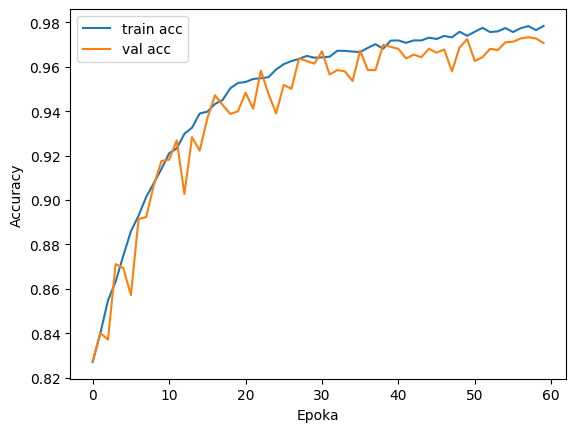

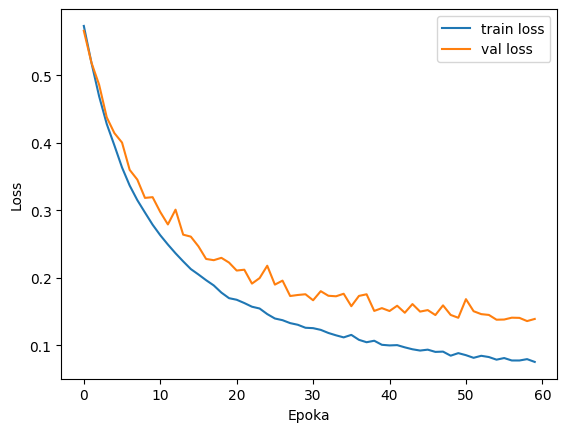

In [11]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoka')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoka')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
import os
from datetime import datetime

# Ustal dzisiejszą datę
today_str = datetime.now().strftime("%Y-%m-%d")

# Ścieżka zapisu modeli
save_dir = f"../model/{today_str}"
os.makedirs(save_dir, exist_ok=True)

# Ścieżki plików
bilstm_path = os.path.join(save_dir, "bilstm_model.keras")
labels_path = os.path.join(save_dir, "labels.txt")

# Zapis modelu
model.save(bilstm_path)

with open(f'../model/{today_str}/labels.txt', 'w+') as f:
    for label in encoder.classes_:
        f.write(label + '\n')

print(f"Modele i etykiety zapisano w folderze: {save_dir}")


Modele i etykiety zapisano w folderze: ../model/2025-09-22
